In [41]:
import scanpy as sc
import scvi
import seaborn as sns
import pandas as pd
import numpy as np

In [3]:
FILE = "datasets/10XGenomics/Targeted_SC3v3_Human_Glioblastoma_Neuroscience_filtered_feature_bc_matrix.h5"
adata = sc.read_10x_h5(FILE)

/Users/simonchervenak/Documents/GitHub/CoNQuiStAdoRES/conq/lib/python3.12/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Users/simonchervenak/Documents/GitHub/CoNQuiStAdoRES/conq/lib/python3.12/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [6]:
sc.pp.filter_genes(adata, min_cells = 10)
sc.pp.highly_variable_genes(adata, n_top_genes = 2000, subset = True, flavor = 'seurat_v3')
scvi.model.SCVI.setup_anndata(adata)
vae = scvi.model.SCVI(adata)
vae.train()

/Users/simonchervenak/Documents/GitHub/CoNQuiStAdoRES/conq/lib/python3.12/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Users/simonchervenak/Documents/GitHub/CoNQuiStAdoRES/conq/lib/python3.12/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Users/simonchervenak/Documents/GitHub/CoNQuiStAdoRES/conq/lib/python3.12/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Users/simonchervenak/Documents/GitHub/CoNQuiStAdoRES/conq/lib/python3.12/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates

Training:   0%|          | 0/400 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=400` reached.


In [13]:
solo = scvi.external.SOLO.from_scvi_model(vae)
solo.train()
df = solo.predict()
df['prediction'] = solo.predict(soft = False)

# df.index = df.index.map(lambda x: x[:-2])

df

ERROR! Session/line number was not unique in database. History logging moved to new session 586
INFO     Creating doublets, preparing SOLO model.                                                                  


/Users/simonchervenak/Documents/GitHub/CoNQuiStAdoRES/conq/lib/python3.12/site-packages/scvi/train/_trainrunner.py:69: UserWarning: `accelerator` has been automatically set to `cpu` although 'mps' exists. If you wish to run on mps backend, use explicitly accelerator=='mps' in train function.In future releases it will become default for mps supported machines.
  accelerator, lightning_devices, device = parse_device_args(
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/simonchervenak/Documents/GitHub/CoNQuiStAdoRES/conq/lib/python3.12/site-packages/lightning/pytorch/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/simonchervenak/Documents/GitHub/CoNQuiStAdoRES/conq/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the v

Training:   0%|          | 0/400 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=400` reached.
/Users/simonchervenak/Documents/GitHub/CoNQuiStAdoRES/conq/lib/python3.12/site-packages/torch/utils/_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
/Users/simonchervenak/Documents/GitHub/CoNQuiStAdoRES/conq/lib/python3.12/site-packages/torch/utils/_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)


,doublet,singlet,prediction
AAACCCAAGGCGATAC-1,0.003560,0.996440,singlet
AAACCCAAGGCTGTAG-1,0.027297,0.972703,singlet
AAACCCACAAGTCCCG-1,0.083146,0.916854,singlet
AAACCCACAGATGCGA-1,0.327143,0.672857,singlet
AAACCCACAGGTGAGT-1,0.100569,0.899431,singlet
...,...,...,...
TTTGGTTTCGCTACAA-1,0.351660,0.648340,singlet
TTTGTTGAGGGTACGT-1,0.226921,0.773079,singlet
TTTGTTGCATCCGGTG-1,0.143690,0.856310,singlet
TTTGTTGGTCTACACA-1,0.059858,0.940142,singlet


In [16]:
df.groupby('prediction').count()

,doublet,singlet
prediction,,
doublet,1515,1515
singlet,4182,4182


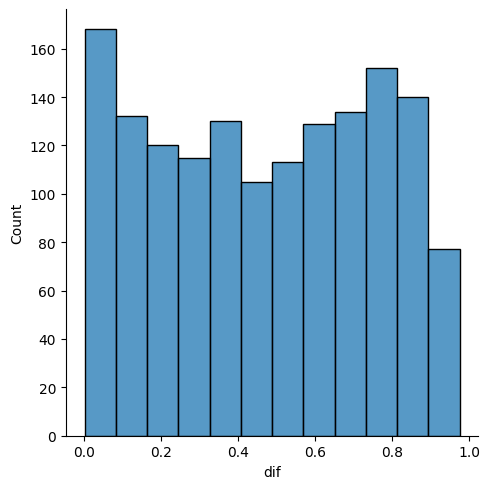

In [17]:
df['dif'] = df.doublet - df.singlet
sns.displot(df[df.prediction == 'doublet'], x = 'dif')


In [18]:
doublets = df[(df.prediction == 'doublet') & (df.dif > 1)]
doublets

,doublet,singlet,prediction,dif


In [19]:
adata = sc.read_10x_h5(FILE)
adata.obs['doublet'] = adata.obs.index.isin(doublets.index)
adata.obs


/Users/simonchervenak/Documents/GitHub/CoNQuiStAdoRES/conq/lib/python3.12/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Users/simonchervenak/Documents/GitHub/CoNQuiStAdoRES/conq/lib/python3.12/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


,doublet
AAACCCAAGGCGATAC-1,False
AAACCCAAGGCTGTAG-1,False
AAACCCACAAGTCCCG-1,False
AAACCCACAGATGCGA-1,False
AAACCCACAGGTGAGT-1,False
...,...
TTTGGTTTCGCTACAA-1,False
TTTGTTGAGGGTACGT-1,False
TTTGTTGCATCCGGTG-1,False
TTTGTTGGTCTACACA-1,False


In [20]:
adata = adata[~adata.obs.doublet]
adata


View of AnnData object with n_obs × n_vars = 5697 × 1186
    obs: 'doublet'
    var: 'gene_ids', 'feature_types', 'genome'

In [24]:
adata.var['mt'] = adata.var.index.str.startswith('MT-')

In [25]:
adata.var

,gene_ids,feature_types,genome,mt
GNB1,ENSG00000078369,Gene Expression,GRCh38,False
TP73,ENSG00000078900,Gene Expression,GRCh38,False
PARK7,ENSG00000116288,Gene Expression,GRCh38,False
TARDBP,ENSG00000120948,Gene Expression,GRCh38,False
MTOR,ENSG00000198793,Gene Expression,GRCh38,False
...,...,...,...,...
MECP2,ENSG00000169057,Gene Expression,GRCh38,False
FLNA,ENSG00000196924,Gene Expression,GRCh38,False
TAZ,ENSG00000102125,Gene Expression,GRCh38,False
RAB39B,ENSG00000155961,Gene Expression,GRCh38,False


In [27]:
ribo_url = "http://software.broadinstitute.org/gsea/msigdb/download_geneset.jsp?geneSetName=KEGG_RIBOSOME&fileType=txt"
ribo_genes = pd.read_table(ribo_url, skiprows=2, header = None)
ribo_genes

,0
0,FAU
1,MRPL13
2,RPL10
3,RPL10A
4,RPL10L
...,...
83,RPS9
84,RPSA
85,RSL24D1
86,RSL24D1P11


In [29]:
adata.var['ribo'] = adata.var_names.isin(ribo_genes[0].values)


In [30]:
adata.obs


,doublet
AAACCCAAGGCGATAC-1,False
AAACCCAAGGCTGTAG-1,False
AAACCCACAAGTCCCG-1,False
AAACCCACAGATGCGA-1,False
AAACCCACAGGTGAGT-1,False
...,...
TTTGGTTTCGCTACAA-1,False
TTTGTTGAGGGTACGT-1,False
TTTGTTGCATCCGGTG-1,False
TTTGTTGGTCTACACA-1,False


In [31]:
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt', 'ribo'], percent_top=None, log1p=False, inplace=True)


In [32]:
adata.var.sort_values('n_cells_by_counts')


,gene_ids,feature_types,genome,mt,ribo,n_cells_by_counts,mean_counts,pct_dropout_by_counts,total_counts
HTR1A,ENSG00000178394,Gene Expression,GRCh38,False,False,0,0.000000,100.000000,0.0
INS,ENSG00000254647,Gene Expression,GRCh38,False,False,0,0.000000,100.000000,0.0
CACNA1S,ENSG00000081248,Gene Expression,GRCh38,False,False,0,0.000000,100.000000,0.0
S100G,ENSG00000169906,Gene Expression,GRCh38,False,False,0,0.000000,100.000000,0.0
CALML5,ENSG00000178372,Gene Expression,GRCh38,False,False,0,0.000000,100.000000,0.0
...,...,...,...,...,...,...,...,...,...
HLA-A,ENSG00000206503,Gene Expression,GRCh38,False,False,5436,17.202387,4.581359,98002.0
ACTG1,ENSG00000184009,Gene Expression,GRCh38,False,False,5437,53.418290,4.563806,304324.0
HNRNPA2B1,ENSG00000122566,Gene Expression,GRCh38,False,False,5450,16.868176,4.335615,96098.0
UBB,ENSG00000170315,Gene Expression,GRCh38,False,False,5465,30.650167,4.072319,174614.0


In [33]:
adata.obs

,doublet,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,total_counts_ribo,pct_counts_ribo
AAACCCAAGGCGATAC-1,False,69,111.0,0.0,0.0,0.0,0.0
AAACCCAAGGCTGTAG-1,False,85,196.0,0.0,0.0,0.0,0.0
AAACCCACAAGTCCCG-1,False,438,3427.0,0.0,0.0,0.0,0.0
AAACCCACAGATGCGA-1,False,266,1352.0,0.0,0.0,0.0,0.0
AAACCCACAGGTGAGT-1,False,331,1636.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...
TTTGGTTTCGCTACAA-1,False,360,2057.0,0.0,0.0,0.0,0.0
TTTGTTGAGGGTACGT-1,False,162,653.0,0.0,0.0,0.0,0.0
TTTGTTGCATCCGGTG-1,False,205,972.0,0.0,0.0,0.0,0.0
TTTGTTGGTCTACACA-1,False,469,4189.0,0.0,0.0,0.0,0.0


In [35]:
sc.pp.filter_genes(adata, min_cells=3)

adata.var.sort_values('n_cells_by_counts')


/Users/simonchervenak/Documents/GitHub/CoNQuiStAdoRES/conq/lib/python3.12/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


,gene_ids,feature_types,genome,mt,ribo,n_cells_by_counts,mean_counts,pct_dropout_by_counts,total_counts,n_cells
GABRA5,ENSG00000186297,Gene Expression,GRCh38,False,False,3,0.000527,99.947341,3.0,3
GGT1,ENSG00000286070,Gene Expression,GRCh38,False,False,3,0.000527,99.947341,3.0,3
DRD1,ENSG00000184845,Gene Expression,GRCh38,False,False,3,0.000527,99.947341,3.0,3
CHRM5,ENSG00000184984,Gene Expression,GRCh38,False,False,3,0.000527,99.947341,3.0,3
SLC18A2,ENSG00000165646,Gene Expression,GRCh38,False,False,3,0.001931,99.947341,11.0,3
...,...,...,...,...,...,...,...,...,...,...
HLA-A,ENSG00000206503,Gene Expression,GRCh38,False,False,5436,17.202387,4.581359,98002.0,5436
ACTG1,ENSG00000184009,Gene Expression,GRCh38,False,False,5437,53.418290,4.563806,304324.0,5437
HNRNPA2B1,ENSG00000122566,Gene Expression,GRCh38,False,False,5450,16.868176,4.335615,96098.0,5450
UBB,ENSG00000170315,Gene Expression,GRCh38,False,False,5465,30.650167,4.072319,174614.0,5465


In [36]:
adata.obs.sort_values('n_genes_by_counts')


,doublet,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,total_counts_ribo,pct_counts_ribo
TTGTTTGGTCTCCTGT-1,False,22,93.0,0.0,0.0,0.0,0.0
CAACCAACAGGCTTGC-1,False,30,76.0,0.0,0.0,0.0,0.0
ATCGTCCAGTCCTACA-1,False,30,115.0,0.0,0.0,0.0,0.0
GCTTGGGAGGTCTACT-1,False,34,92.0,0.0,0.0,0.0,0.0
ACCATTTCATCAGTCA-1,False,34,90.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...
CTCGAGGAGCAATAGT-1,False,742,15487.0,0.0,0.0,0.0,0.0
CATTCTATCATTCACT-1,False,747,10483.0,0.0,0.0,0.0,0.0
TTAGTCTTCTTGCAGA-1,False,755,11245.0,0.0,0.0,0.0,0.0
AAACGCTGTCTTACTT-1,False,756,8942.0,0.0,0.0,0.0,0.0


In [37]:
# sc.pp.filter_cells(adata, min_genes=200)

In [39]:
adata.var_names_make_unique()

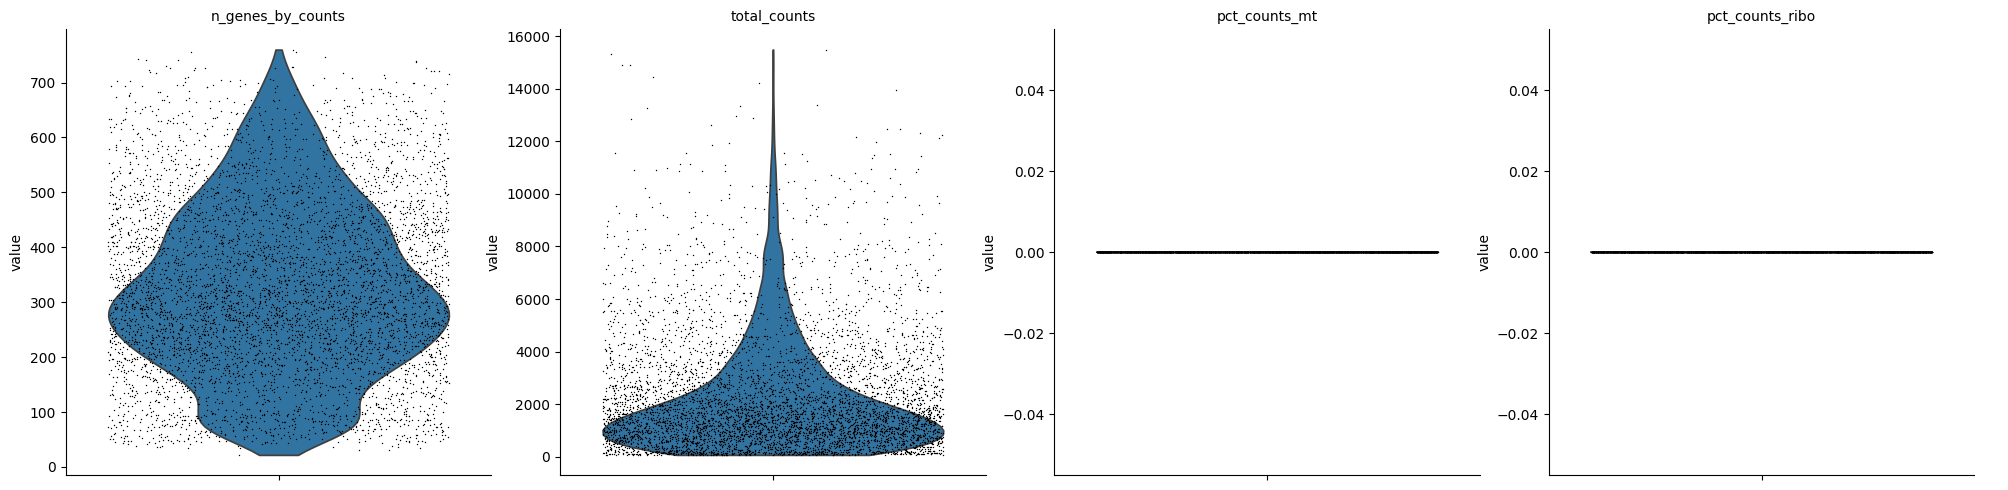

In [40]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt', 'pct_counts_ribo'], 
             jitter=0.4, multi_panel=True)

In [43]:
upper_lim = np.quantile(adata.obs.n_genes_by_counts.values, .98)
adata = adata[adata.obs.n_genes_by_counts < upper_lim]
adata.X.sum(axis = 1)
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

/Users/simonchervenak/Documents/GitHub/CoNQuiStAdoRES/conq/lib/python3.12/site-packages/scanpy/preprocessing/_normalization.py:216: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


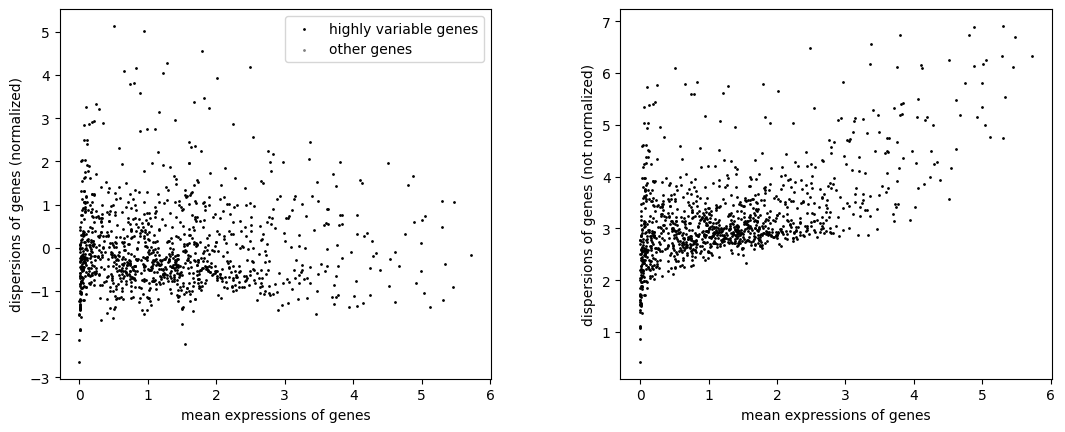

In [46]:
sc.pp.highly_variable_genes(adata, n_top_genes = 2000)
sc.pl.highly_variable_genes(adata)


/Users/simonchervenak/Documents/GitHub/CoNQuiStAdoRES/conq/lib/python3.12/site-packages/scanpy/preprocessing/_simple.py:710: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


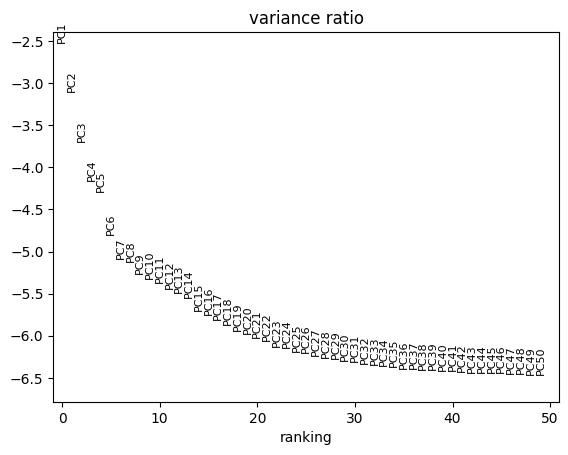

In [47]:
adata = adata[:, adata.var.highly_variable]
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt', 'pct_counts_ribo'])
sc.pp.scale(adata, max_value=10)
sc.tl.pca(adata, svd_solver='arpack')
sc.pl.pca_variance_ratio(adata, log=True, n_pcs = 50)



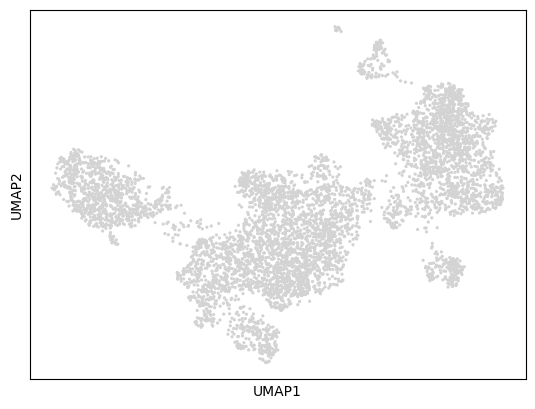

In [48]:
sc.pp.neighbors(adata, n_pcs = 30)
sc.tl.umap(adata)
sc.pl.umap(adata)


/var/folders/my/xjpgt3ss01991yghb67xgjs80000gn/T/ipykernel_89256/1806692371.py:1: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata, resolution = 0.5)


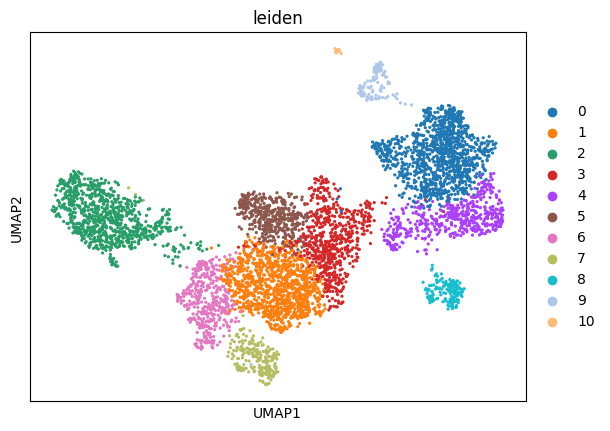

In [49]:
sc.tl.leiden(adata, resolution = 0.5)
adata.obs
sc.pl.umap(adata, color=['leiden'])


In [51]:
adata.obs.leiden

AttributeError: 'DataFrame' object has no attribute 'leiden'

In [50]:
adata = sc.read_10x_h5(FILE)
adata.obs.Sample.unique().tolist()


/Users/simonchervenak/Documents/GitHub/CoNQuiStAdoRES/conq/lib/python3.12/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Users/simonchervenak/Documents/GitHub/CoNQuiStAdoRES/conq/lib/python3.12/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


AttributeError: 'DataFrame' object has no attribute 'Sample'